# Fig 5d: TP53 site selection vs experimental mutagenesis

In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
import sys
sys.path.append('../../')
from consensus_variables import *

In [3]:
data_dir = '../../data/tp53_data'
output_dir = './plots'

In [4]:
table_file = os.path.join(data_dir,'TP53_merged_data.tsv')

In [5]:
table = pd.read_csv(table_file,sep='\t')

# only keep those sites with a experimental saturation value
print(table.shape)
table = table[~(table["experimental_score"].isna())].reset_index()
print(table.shape)

(3984, 26)
(1920, 27)


In [6]:
table['consequence_normal'].value_counts()

consequence_normal
missense                 234
synonymous                16
nonsense                  15
essential_splice          12
splice_region_variant      9
intron_variant             4
Name: count, dtype: int64

In [7]:
def group_normal_consequence(r):
    if r['consequence_normal'] == 'missense':
        return 'missense'
    elif r['consequence_normal'] == 'nonsense' or r['consequence_normal'] == 'essential_splice':
        return 'truncating'
    elif r['consequence_normal'] == 'synonymous':
        return 'synonymous'
    elif r['consequence_normal'] == 'intron_variant' or r['consequence_normal'] == 'non_coding_exon_region':
        return 'noncoding'
    elif r['consequence_normal'] == 'splice_region_variant':
        return 'other'
    else:
        return 'not_observed'

In [8]:
table['consequence_normal_formatted'] = table.apply(group_normal_consequence,axis=1)

In [9]:
table['consequence_normal_formatted'].value_counts()

consequence_normal_formatted
not_observed    1630
missense         234
truncating        27
synonymous        16
other              9
noncoding          4
Name: count, dtype: int64

In [10]:
list(table.columns)

['index',
 'chr',
 'pos',
 'ref',
 'alt',
 'consequence_intogen',
 'count_intogen_cancer',
 'count_intogen_bladder',
 'consequence_genie',
 'count_genie',
 'freq_genie',
 'count_bladder_genie',
 'freq_bladder_genie',
 'boostdm_score_cancer',
 'boostdm_class_cancer',
 'boostdm_score_bladder',
 'boostdm_class_bladder',
 'oncogenic',
 'consequence_normal',
 'count_normal',
 'experimental_score',
 'p_value_experimental',
 'freq_intogen_cancer',
 'freq_intogen_bladder',
 'freq_normal',
 'site_selection',
 'p_value',
 'consequence_normal_formatted']

In [11]:
def group(r):
    if r['consequence_normal_formatted'] == 'not_observed':
        return 'not_observed'
    elif r['p_value'] < 1e-5:
        return 'significant'
    elif r['p_value'] >= 1e-5:
        return 'not_significant'
    

In [12]:
table['group_normal'] = table.apply(group,axis=1)

In [13]:
table['group_normal'].value_counts()

group_normal
not_observed       1630
not_significant     263
significant          23
Name: count, dtype: int64

In [14]:
table.groupby(by='group_normal')['freq_intogen_bladder'].mean()

group_normal
not_observed       0.000100
not_significant    0.000439
significant        0.005316
Name: freq_intogen_bladder, dtype: float64

### site selection groups as independent variable

In [15]:
size_groups = pd.DataFrame({'size':table.groupby(by='group_normal')['chr'].count()}).reset_index()

In [16]:
size_groups

,group_normal,size
0,not_observed,1630
1,not_significant,263
2,significant,23


In [17]:
# Define the custom color palette
custom_palette = {
    'significant': 'blue',       # Blue for significant
    'not_significant': '#6baed6',  # Lighter blue for not significant
    'not_observed': 'gray'       # Gray for not observed
}


### Half violin

In [18]:
# Reusable plotting function adapted for grouped data
def plot_half_violin_group(ax, data, x_col, y_col, group_order, palette, title, ylabel=None):
    sns.violinplot(
        data=data,
        ax=ax,
        x=x_col,
        y=y_col,
        hue=x_col,
        hue_order=group_order,
        order=group_order,
        palette=palette,
        inner=None,
        linewidth=0,
        bw=0.2,
        cut=0,
        density_norm='width',
        zorder = 1
    )

    ymin, ymax = ax.get_ylim()

    # Cover left half
    for i, group in enumerate(group_order):
        ax.add_patch(plt.Rectangle((i - 0.41, ymin), 0.39, ymax - ymin, color='white', zorder=2))

    group_order = ['not_observed', 'not_significant', 'significant']
    x_offset = -0.25  # fixed offset if you want all dots shifted
    jitter_width = 0.1  # match seaborn's jitter
    dot_size = 20

    for i, group in enumerate(group_order):
        group_data = data[data[x_col] == group]
        y_vals = group_data[y_col]
        # x_vals = [i + x_offset] * len(y_vals)# + np.random.uniform(-jitter_width, jitter_width, size=len(y_vals))
        x_vals = i + x_offset + np.random.uniform(-jitter_width, jitter_width, size=len(y_vals))
        ax.scatter(x_vals,
                    y_vals,
                    color=palette[group],
                    alpha=0.6,
                    s=dot_size,
                    edgecolor='none',
                    linewidth=0,
                    label=group,
                    zorder = 3)

    if ylabel:
        ax.set_ylabel(ylabel)
    else:
        ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(title)
    ax.spines[['top', 'right']].set_visible(False)
    ax.legend([], [], frameon=False)

    # Update x-axis tick labels with group sizes
    xtick_labels = [
        f"Not\nobserved\n(N={size_groups[size_groups[x_col]=='not_observed']['size'].values[0]:,})",
        f"Not\nsignificant\n(N={size_groups[size_groups[x_col]=='not_significant']['size'].values[0]:,})",
        f"Significant\n(N={size_groups[size_groups[x_col]=='significant']['size'].values[0]:,})"
    ]
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(xtick_labels, rotation=0)
    
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))


/tmp/ipykernel_3174266/2426138050.py:3: FutureWarning: 

The `bw` parameter is deprecated in favor of `bw_method`/`bw_adjust`.
Setting `bw_method=0.2`, but please see docs for the new parameters
and update your code. This will become an error in seaborn v0.15.0.

  sns.violinplot(


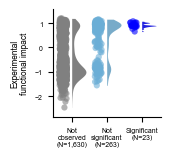

In [19]:
TP53_experimental_saturation_figure = os.path.join(output_dir,'Fig5d_TP53_experimental_saturation_fig.half_violin.pdf')

# Setup
fig, axs = plt.subplots(1, 1, figsize=(1.4, 1.4))

# Plot each panel
group_order = ['not_observed', 'not_significant', 'significant']
plot_half_violin_group(axs, table, 'group_normal', 'experimental_score', group_order, custom_palette, '', ylabel='Experimental\nfunctional impact')

# Finalize
# plt.tight_layout()
plt.savefig(TP53_experimental_saturation_figure, bbox_inches = 'tight', dpi = 300)
plt.show()
